# Federated Learning with P4P Defense and Voting-based Detection

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
import statistics
import os
import pandas as pd
from collections import Counter

## 1. Config

In [2]:
CONFIG = {
    "num_clients": 11,
    "num_malicious": 5,
    "num_rounds": 15,
    "epochs_per_client": 5,
    "batch_size": 32,
    "learning_rate": 0.001,
    "server_learning_rate": 1.0,  # Global learning rate for FedSGD
    # --- Defense Parameters ---
    "volatility_threshold": 0.2,
    "suspicion_threshold": 2,
    "suspicion_increment": 2,
    "suspicion_decrement": 0.2,
    # --- Attack Configurations ---
    "backdoor_target_label": 1, 
    "backdoor_trigger_feature": "Flow Duration",  
    "backdoor_trigger_value": 99999.0,  
    "label_flipping_rate": 0.8,  
    "csv_file": "/kaggle/input/iotdiad/IoTDIAD_processed.csv",  
    # --- Data Partitioning ---
    "partition_type": "non-iid", # "iid" or "non-iid"
    "dirichlet_alpha": 0.5 # Only used for "non-iid"
}

## 2.Model

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## 3. Data handling

In [4]:
def get_custom_data():
    df = pd.read_csv(CONFIG["csv_file"])

    feature_columns = [col for col in df.columns if col != 'label']
    X = df[feature_columns].values
    y = df['label'].values  

    num_classes = df['label'].nunique()
    CONFIG["num_classes"] = num_classes

    X_tensor = torch.FloatTensor(X)  
    y_tensor = torch.LongTensor(y)
    
    # Split train/test (80/20)
    train_size = int(0.8 * len(X_tensor))
    train_dataset = TensorDataset(X_tensor[:train_size], y_tensor[:train_size])
    test_dataset = TensorDataset(X_tensor[train_size:], y_tensor[train_size:])
    
    print(f"Loaded {len(train_dataset)} train samples, {len(test_dataset)} test samples.")
    print(f"Feature columns: {feature_columns}")
    print(f"Unique labels: {np.unique(y).tolist()}, num_classes: {num_classes}")

    CONFIG["feature_columns"] = feature_columns
    
    return train_dataset, test_dataset

In [5]:
def create_split(dataset, num_clients):
    num_items_per_client = int(len(dataset) / num_clients)
    dict_users, all_idxs = {}, list(range(len(dataset)))
    for i in range(num_clients):
        dict_users[i] = set(np.random.choice(all_idxs, num_items_per_client, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [6]:
def partition_noniid(dataset, num_clients, alpha=0.5, seed=42):
    """
    Partitions a dataset into Non-IID subsets using a Dirichlet distribution.
    """
    np.random.seed(seed)
    labels = np.array([y.item() for _, y in dataset])
    num_classes = len(np.unique(labels))
    idxs = np.arange(len(labels))
    
    # Get indices for each class
    class_indices = [idxs[labels == c] for c in range(num_classes)]
    
    client_dict = {i: [] for i in range(num_clients)}

    # Distribute indices for each class among clients
    for c_indices in class_indices:
        np.random.shuffle(c_indices)
        # Generate proportions using Dirichlet distribution
        proportions = np.random.dirichlet(alpha * np.ones(num_clients))
        
        # Calculate split points
        split_points = (np.cumsum(proportions) * len(c_indices)).astype(int)[:-1]
        
        # Split and assign to clients
        split_class = np.split(c_indices, split_points)
        for cid, idx_split in enumerate(split_class):
            client_dict[cid].extend(idx_split.tolist())

    # Convert lists to sets for consistency with your original create_split
    for cid in client_dict:
        client_dict[cid] = set(client_dict[cid])
        
    return client_dict

## 4. Defense

In [7]:
def create_backdoor_test_set(dataset, target_label, trigger_feature, trigger_value):
    poisoned_features, poisoned_labels = [], []
    feature_idx = CONFIG["feature_columns"].index(trigger_feature) if trigger_feature in CONFIG["feature_columns"] else -1
    
    if feature_idx == -1:
        print(f"Error: Trigger feature {trigger_feature} not in selected features.")
        return None
    
    for features, label in dataset:
        if label.item() != target_label: 
            poisoned_feat = features.clone()
            poisoned_feat[feature_idx] = trigger_value  
            poisoned_features.append(poisoned_feat)
            poisoned_labels.append(torch.tensor(target_label))  
    
    return TensorDataset(torch.stack(poisoned_features), torch.stack(poisoned_labels)) if poisoned_features else None

In [8]:
def detect_malicious_clients_voting(probe_responses, client_ids):
    n = len(client_ids)
    malicious_votes = {cid: 0 for cid in client_ids}
    X = np.array(probe_responses).reshape(n, -1)

    try:
        km = KMeans(n_clusters=2, random_state=42, n_init=10).fit(X)
        km_labels = km.labels_
        most_common = Counter(km_labels).most_common(1)[0][0]
        for i, cid in enumerate(client_ids):
            if km_labels[i] != most_common:
                malicious_votes[cid] += 1
    except Exception:
        pass

    try:
        db = DBSCAN(eps=0.5, min_samples=2).fit(X)
        db_labels = db.labels_
        for i, cid in enumerate(client_ids):
            if db_labels[i] == -1:
                malicious_votes[cid] += 1
    except Exception:
        pass

    try:
        iso = IsolationForest(contamination=0.3, random_state=42)
        iso_labels = iso.fit_predict(X)
        for i, cid in enumerate(client_ids):
            if iso_labels[i] == -1:
                malicious_votes[cid] += 1
    except Exception:
        pass

    suspects = [cid for cid, v in malicious_votes.items() if v >= 2]
    return suspects, malicious_votes

## 5. Client

In [9]:
class Client:
    def __init__(self, client_id, dataset, indices, is_malicious=False, attack_type='backdoor'):
        self.client_id = client_id
        self.is_malicious = is_malicious
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        subset = Subset(dataset, list(indices))
        
        if self.is_malicious:
            if attack_type == 'backdoor':
                self.dataset = create_backdoor_test_set(subset, CONFIG["backdoor_target_label"], 
                                                       CONFIG["backdoor_trigger_feature"], 
                                                       CONFIG["backdoor_trigger_value"])
            elif attack_type == 'label_flipping':
                features_list, labels_list = [], []
                num_to_flip = int(len(subset) * 0.8)  
                indices_to_flip = set(np.random.choice(range(len(subset)), num_to_flip, replace=False))
                for i, (feat, label) in enumerate(subset):
                    if i in indices_to_flip:
                        # random flip to a different label
                        new_label = np.random.choice([x for x in range(CONFIG["num_classes"]) if x != label.item()])
                        labels_list.append(torch.tensor(new_label))
                    else:
                        labels_list.append(torch.tensor(label.item()))
                    features_list.append(feat)
                self.dataset = TensorDataset(torch.stack(features_list), torch.stack(labels_list))
        else:
            self.dataset = subset
        
        self.dataloader = DataLoader(self.dataset, batch_size=CONFIG["batch_size"], shuffle=True) if self.dataset and len(self.dataset) > 0 else None

    def train(self, model):
        if not self.dataloader: return None
        local_model = copy.deepcopy(model).to(self.device)
        local_model.train()
        optimizer = optim.SGD(local_model.parameters(), lr=CONFIG["learning_rate"])
        criterion = nn.CrossEntropyLoss()
        for _ in range(CONFIG["epochs_per_client"]):
            for data, target in self.dataloader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = local_model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
        return {name: local_model.state_dict()[name] - model.state_dict()[name] for name in model.state_dict()}

    def generate_probe_response(self, model, probe_vector):
        if not self.dataloader: return 0.0
        local_model = copy.deepcopy(model).to(self.device)
        try:
            data, target = next(iter(self.dataloader))
        except StopIteration: return 0.0
        data, target = data.to(self.device), target.to(self.device)
        local_model.zero_grad()
        output = local_model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        grads = [p.grad for p in local_model.parameters() if p.grad is not None]
        if not grads: return 0.0
        local_grad_flat = torch.cat([g.view(-1) for g in grads])
        if local_grad_flat.numel() != probe_vector.numel(): return 0.0
        return torch.nn.functional.cosine_similarity(local_grad_flat, probe_vector, dim=0).item()

## 6. Server

In [10]:
class Server:
    def __init__(self, clients, input_size, num_classes):
        self.clients = clients
        self.input_size = input_size
        self.model = SimpleMLP(input_size, num_classes)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.previous_avg_update = None
        self.malicious_clients_history = set()
        self.suspicion_scores = {c.client_id: 0 for c in self.clients}
        
    def aggregate_updates(self, updates, client_weights, strategy='fedavg'):
        aggregated_update = {name: torch.zeros_like(self.model.state_dict()[name]) for name in self.model.state_dict()}
        total_weight = sum(client_weights)
        if total_weight == 0:
            print("  Warning: All clients were filtered out. Skipping model update.")
            self.previous_avg_update = None
            return

        # --- Step 1: Aggregate weighted updates from clients ---
        for i, update in enumerate(updates):
            if update is not None and client_weights[i] > 0:
                weight = client_weights[i] / total_weight
                for name in aggregated_update:
                    aggregated_update[name] += update[name] * weight
        
        self.previous_avg_update = aggregated_update # For P4P defense

        # --- Step 2: Apply aggregated update to the global model based on strategy ---
        with torch.no_grad():
            for name in self.model.state_dict():
                if strategy == 'fedavg':
                    self.model.state_dict()[name] += aggregated_update[name]
                elif strategy == 'fedsgd':
                    # For FedSGD, apply the aggregated update with a server-side learning rate
                    self.model.state_dict()[name] += CONFIG["server_learning_rate"] * aggregated_update[name]

    def evaluate(self, dataloader):
        self.model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, target in dataloader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        return 100 * correct / total if total > 0 else 0

    def run_simulation(self, use_defense=False, attack_type='backdoor', aggregation_strategy='fedavg'):
        main_task_accuracies, attack_success_rates = [], []
        train_dataset, test_dataset = get_custom_data()
        test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"])
        asr_loader = None
        if attack_type == 'backdoor':
            asr_test_set = create_backdoor_test_set(test_dataset, CONFIG["backdoor_target_label"], 
                                                    CONFIG["backdoor_trigger_feature"], 
                                                    CONFIG["backdoor_trigger_value"])
            if asr_test_set:
                asr_loader = DataLoader(asr_test_set, batch_size=CONFIG["batch_size"])

        for round_num in range(CONFIG["num_rounds"]):
            defense_status = "ON" if use_defense else "OFF"
            print(f"--- Round {round_num+1}/{CONFIG['num_rounds']} (Attack: {attack_type.upper()}, Defense: {defense_status}, Strategy: {aggregation_strategy.upper()}) ---")
            
            client_weights = [1.0 if c.client_id not in self.malicious_clients_history else 0.0 for c in self.clients]
            
            if use_defense and self.previous_avg_update is not None:
                active_clients = [c for c in self.clients if c.client_id not in self.malicious_clients_history]
                if len(active_clients) > 1:
                    probe_vector_flat = -torch.cat([v.view(-1) for v in self.previous_avg_update.values()]).to(self.device)
                    responses = {c.client_id: c.generate_probe_response(self.model, probe_vector_flat) for c in active_clients}
                    client_ids = [c.client_id for c in active_clients]
                    response_values = [responses[cid] for cid in client_ids]

                    if len(response_values) > 1 and statistics.stdev(response_values) > CONFIG["volatility_threshold"]:
                        print(f"  Volatility detected (StdDev: {statistics.stdev(response_values):.2f}). Running voting-based detectors.")
                        X = np.array(response_values).reshape(-1, 1)
                        suspects, votes = detect_malicious_clients_voting(X, client_ids)
                        print(f"  Voting votes: {votes}")
                        print(f"  Voting suspects this round: {suspects}")

                        for cid in client_ids:
                            if cid in suspects:
                                self.suspicion_scores[cid] += CONFIG["suspicion_increment"]
                                client_weights[cid] = 0.0
                                self.suspicion_scores[cid] += 0.5  
                                print(f"   => Client {cid} is suspicious. Score: {self.suspicion_scores[cid]}")
                            else:
                                self.suspicion_scores[cid] = max(0, self.suspicion_scores[cid] - CONFIG["suspicion_decrement"])
                    else:
                        if len(response_values) > 1:
                            print(f"  No significant volatility (StdDev: {statistics.stdev(response_values):.2f}).")
                        for client in active_clients:
                            self.suspicion_scores[client.client_id] = max(0, self.suspicion_scores[client.client_id] - CONFIG["suspicion_decrement"])

            for client in self.clients:
                if self.suspicion_scores[client.client_id] > CONFIG["suspicion_threshold"]:
                    if client.client_id not in self.malicious_clients_history:
                        print(f"  !!! Client {client.client_id} crossed suspicion threshold and is permanently removed. !!!")
                        self.malicious_clients_history.add(client.client_id)
                        client_weights[client.client_id] = 0.0

            updates = [c.train(self.model) for c in self.clients]
            self.aggregate_updates(updates, client_weights, strategy=aggregation_strategy)

            main_acc = self.evaluate(test_loader)
            asr = 0.0
            if asr_loader:
                asr = self.evaluate(asr_loader)
            main_task_accuracies.append(main_acc)
            attack_success_rates.append(asr)
            print(f"  Main Task Accuracy: {main_acc:.2f}%")
            if attack_type == 'backdoor':
                print(f"  Attack Success Rate (ASR): {asr:.2f}%")

        return main_task_accuracies, attack_success_rates

## 7. Main Execution

In [11]:
os.environ["OMP_NUM_THREADS"] = "1"
train_dataset, test_dataset = get_custom_data()
input_size = len(CONFIG["feature_columns"])
print(f"Input size (num features): {input_size}")

if CONFIG["partition_type"] == "non-iid":
    print(f"Creating Non-IID partition with alpha={CONFIG['dirichlet_alpha']}")
    client_indices = partition_noniid(train_dataset, CONFIG["num_clients"], alpha=CONFIG["dirichlet_alpha"])
else:
    print("Creating IID partition")
    client_indices = create_split(train_dataset, CONFIG["num_clients"])

Loaded 280000 train samples, 70000 test samples.
Feature columns: ['Src Port', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Packet Length Min', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'Down/Up Ratio', 'Bwd Segment Size Avg', 'FWD Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min', 'Label']
Unique labels: [0, 1, 2, 3, 4, 5, 6], num_classes: 7
Input size (num features): 30
Creating Non-IID partition with alpha=0.5


### FedAvg

In [12]:
scenarios = {
    "Benign_Avg": {'attack': 'benign', 'defense': False, 'color': 'green', 'style': '-', 'strategy': 'fedavg'},
    "LabelFlip_NoDefense_Avg": {"attack": "label_flipping", "defense": False, "color": "red", "style": "--", 'strategy': 'fedavg'},
    "LabelFlip_WithDefense_Avg": {"attack": "label_flipping", "defense": True, "color": "blue", "style": ":", 'strategy': 'fedavg'},
}

In [13]:
results = {}
for name, params in scenarios.items():
    print("\n" + "="*25 + f" STARTING SCENARIO: {name} " + "="*25) 
    all_clients = [Client(i, train_dataset, client_indices[i], 
                          is_malicious=(False if params['attack'] == 'benign' else (i < CONFIG['num_malicious'])), 
                          attack_type=params["attack"]) 
                   for i in range(CONFIG["num_clients"])] # Create clients for this scenario
    server = Server(all_clients, input_size, CONFIG["num_classes"])
    acc, asr = server.run_simulation(use_defense=params["defense"], 
                                     attack_type=params["attack"], 
                                     aggregation_strategy=params["strategy"])
    results[name] = {"acc": acc, "asr": asr}


========================= STARTING SCENARIO: Benign_Avg =========================
Loaded 280000 train samples, 70000 test samples.
Feature columns: ['Src Port', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Packet Length Min', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'Down/Up Ratio', 'Bwd Segment Size Avg', 'FWD Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min', 'Label']
Unique labels: [0, 1, 2, 3, 4, 5, 6], num_classes: 7
--- Round 1/15 (Attack: BENIGN, Defense: OFF, Strategy: FEDAVG) ---
  Main Task Accuracy: 0.63%
--- Round 2/15 (Attack: BENIGN, Defense: OFF, Strategy: FEDAVG) ---
  Main Task Accuracy: 0.94%
--- Round 3/15 (Attack: BENIGN, Defense: OFF, Strategy: FEDAVG) ---
  Main Task Accuracy: 

## 8. Results Plotting


Comparison plot has been saved to: final_temporary_exclusion_voting_comparison_iotdiad.png


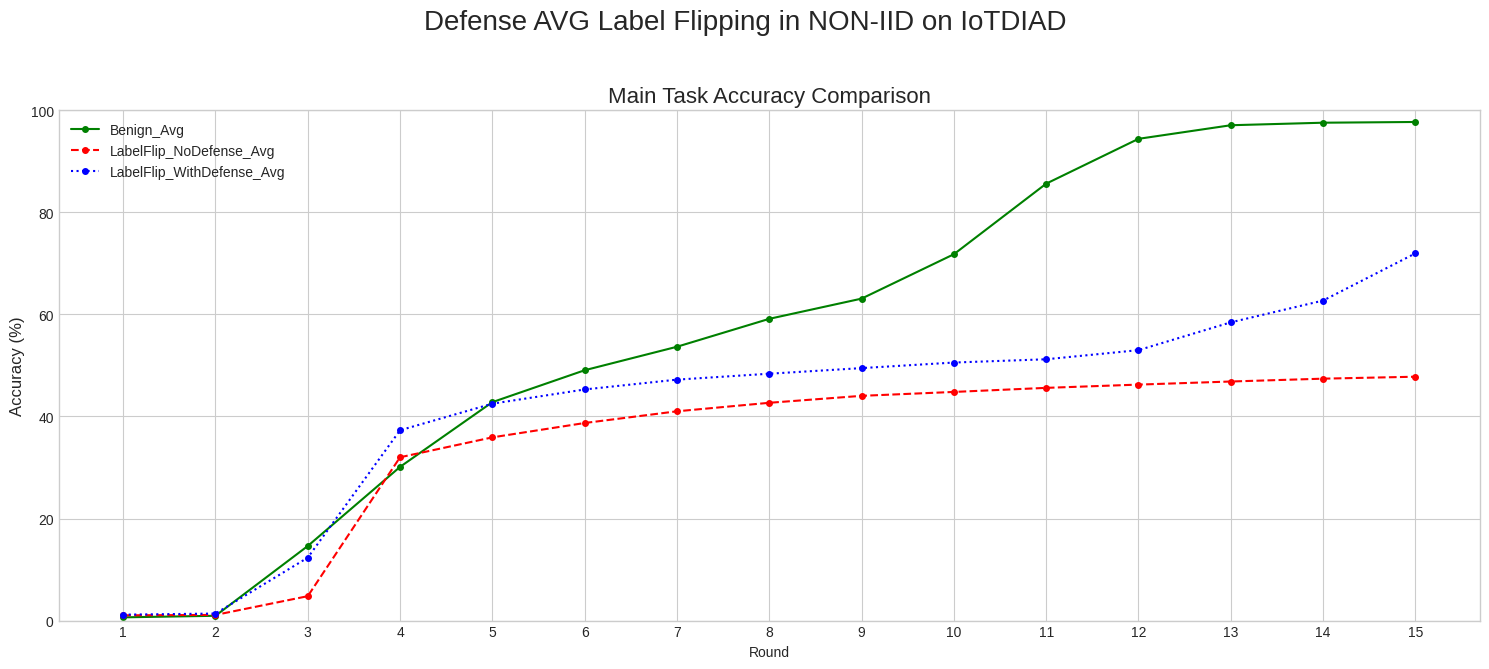

In [14]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(1, figsize=(15, 7))
for name, data in results.items():
    params = scenarios[name]
    ax1.plot(range(1, CONFIG["num_rounds"] + 1), data["acc"], color=params["color"], linestyle=params["style"], marker='o', markersize=4, label=name)
ax1.set_xticks(range(1, CONFIG["num_rounds"] + 1))
ax1.set_title('Main Task Accuracy Comparison', fontsize=16)
ax1.set_xlabel('Round', fontsize=10)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True)
ax1.set_ylim(0, 100)
plt.suptitle('Defense AVG Label Flipping in NON-IID on IoTDIAD', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("final_temporary_exclusion_voting_comparison_iotdiad.png")
print("\nComparison plot has been saved to: final_temporary_exclusion_voting_comparison_iotdiad.png")

### FedSgd

In [15]:
scenarios = {
    "Benign_Sgd": {'attack': 'benign', 'defense': False, 'color': 'green', 'style': '-', 'strategy': 'fedsgd'},
    "LabelFlip_NoDefense_Sgd": {"attack": "label_flipping", "defense": False, "color": "red", "style": "--", 'strategy': 'fedsgd'},
    "LabelFlip_WithDefense_Sgd": {"attack": "label_flipping", "defense": True, "color": "blue", "style": ":", 'strategy': 'fedsgd'},
}

In [16]:
results = {}
for name, params in scenarios.items():
    print("\n" + "="*25 + f" STARTING SCENARIO: {name} " + "="*25) 
    all_clients = [Client(i, train_dataset, client_indices[i], 
                          is_malicious=(False if params['attack'] == 'benign' else (i < CONFIG['num_malicious'])), 
                          attack_type=params["attack"]) 
                   for i in range(CONFIG["num_clients"])] # Create clients for this scenario
    server = Server(all_clients, input_size, CONFIG["num_classes"])
    acc, asr = server.run_simulation(use_defense=params["defense"], 
                                     attack_type=params["attack"], 
                                     aggregation_strategy=params["strategy"])
    results[name] = {"acc": acc, "asr": asr}


========================= STARTING SCENARIO: Benign_Sgd =========================
Loaded 280000 train samples, 70000 test samples.
Feature columns: ['Src Port', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Packet Length Min', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'Down/Up Ratio', 'Bwd Segment Size Avg', 'FWD Init Win Bytes', 'Fwd Seg Size Min', 'Idle Mean', 'Idle Max', 'Idle Min', 'Label']
Unique labels: [0, 1, 2, 3, 4, 5, 6], num_classes: 7
--- Round 1/15 (Attack: BENIGN, Defense: OFF, Strategy: FEDSGD) ---
  Main Task Accuracy: 0.92%
--- Round 2/15 (Attack: BENIGN, Defense: OFF, Strategy: FEDSGD) ---
  Main Task Accuracy: 1.13%
--- Round 3/15 (Attack: BENIGN, Defense: OFF, Strategy: FEDSGD) ---
  Main Task Accuracy: 

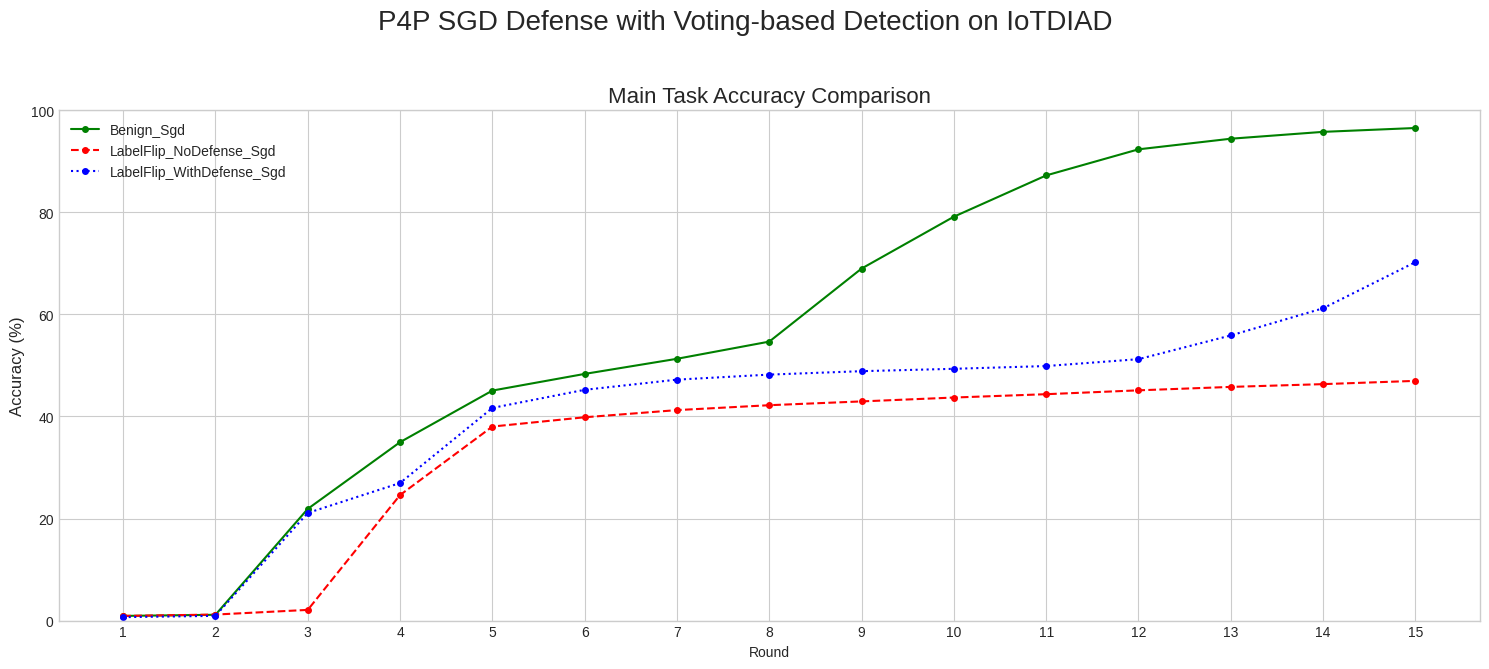

In [17]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(1, figsize=(15, 7))
for name, data in results.items():
    params = scenarios[name]
    ax1.plot(range(1, CONFIG["num_rounds"] + 1), data["acc"], color=params["color"], linestyle=params["style"], marker='o', markersize=4, label=name)
ax1.set_xticks(range(1, CONFIG["num_rounds"] + 1))
ax1.set_title('Main Task Accuracy Comparison', fontsize=16)
ax1.set_xlabel('Round', fontsize=10)
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True)
ax1.set_ylim(0, 100)
plt.suptitle('P4P SGD Defense with Voting-based Detection on IoTDIAD', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("sgd_iotdiad.png")